# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import requests

device

'cuda'

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip"
response = requests.get(url)
with open("data.txt.zip", "wb") as file:
    file.write(response.content)

In [2]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [3]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Скейлим наши данные
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
pd.DataFrame(X_train_scaled)

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,1.078786,0.391566,1.826962,0.466361,-0.476621,-0.275266,-1.551924,-1.311105,0.389093,-0.665402,...,-0.084995,0.106413,0.144257,-0.236180,0.047430,-0.355855,0.544084,-0.470477,-0.255366,0.042637
1,0.879511,0.332631,1.748961,0.723345,-0.166769,-1.189729,0.764797,0.109714,1.422683,0.416934,...,-0.314004,0.304413,-0.068758,0.053729,-0.634467,-0.435794,0.556059,0.570861,0.209341,1.161118
2,1.245515,0.592771,1.337550,0.752153,-0.002899,-0.699856,-0.061323,-0.069912,1.167910,-0.073176,...,-0.395974,0.565220,-0.758259,-0.282931,-0.026058,0.223918,-0.508889,-0.338081,0.107828,-0.090122
3,0.799787,-0.061214,0.784000,0.089197,0.327463,-1.297159,0.509977,-1.073557,-0.015553,-1.262565,...,0.586855,-0.562444,-0.479423,-0.890199,-0.796124,0.568335,-0.262505,0.409924,0.973205,0.795200
4,1.247663,0.793377,1.657449,0.449177,-0.408652,-0.564673,-0.692545,-0.952369,0.843389,-0.143557,...,-0.181284,0.097564,0.192974,-0.585048,-0.113758,-0.219524,0.448546,0.258400,0.194381,1.244057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463710,0.492756,-0.335549,-0.084459,-0.656073,-1.675351,0.285865,-1.493532,-0.686944,0.832549,-1.057817,...,0.124674,0.990884,-0.324914,-0.394720,1.530260,0.085898,-0.001212,-0.322543,-0.617490,-0.698879
463711,-0.124305,0.200903,-0.926062,-0.894906,-1.645646,-0.372671,0.621834,-0.478465,0.760305,-1.016607,...,-0.371914,1.868821,-0.550887,-0.651741,2.409392,0.031123,-1.187413,-0.119730,0.471477,-0.343674
463712,0.162956,0.007057,0.836966,0.069338,-0.368921,0.277246,-2.079127,-0.029297,-0.220203,-0.721385,...,-0.102787,0.438779,-0.407079,-0.822190,0.863293,-0.687453,-0.265296,-0.663950,0.014553,-0.246412
463713,0.247032,0.249674,-0.407125,-1.275544,-2.292766,-0.370757,-0.105394,0.164310,-0.144972,0.032255,...,0.367707,1.480623,0.128418,-0.701047,1.255686,0.638535,0.343939,0.534925,0.469997,0.702437


In [5]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [6]:
set_random_seed(42)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

In [8]:
model = Ridge() # создаем экземпляр класса Ridge и фитим(тренеруем) его на наших данных
model.fit(X_train_scaled, y_train)

Ridge()

In [9]:
y_pred = model.predict(X_test_scaled)
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

9.510160820470436

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [10]:
y_mean = np.mean(y_train) # Считаем среднее значение по целевой переменной для оценивания метрики
y_constant_predictions = [y_mean] * len(y_test)

In [11]:
best_rmse_metric = mean_squared_error(y_constant_predictions, y_test, squared=False)
best_rmse_metric # считаем и выводим среднее по RMSE

10.85246390513634

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [12]:
set_random_seed(44)

In [13]:
lr = 0.01
num_epoches = 10
input_size = len(df.columns) - 1 # df - исходная таблица с 91 колонкой (1 колонка - целевые)
output_size = 1
batch_size = 10

In [14]:
#делаем датасет тензорным, готовим к даталоадеру
train_dataset = TensorDataset(torch.from_numpy(X_train_scaled), torch.from_numpy(y_train))
test_dataset = TensorDataset(torch.from_numpy(X_test_scaled), torch.from_numpy(y_test))

# Создаем даталоадеры
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=1, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=1, shuffle = True)

In [15]:
# ⸂⸂⸜(രᴗര๑)⸝⸃⸃ Good luck!

# Создадим класс модели со Слоями https://github.com/hse-ds/iad-deep-learning/blob/master/2023/seminars/03.%20Image%20Classification/03_Image_Classification.ipynb
# С одним линейным слыоем, объявлениеим и форвард пасом
class LinearRegressionModel(nn.Module):

    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

In [16]:
model = LinearRegressionModel(input_size, output_size)
model.to(device)

LinearRegressionModel(
  (linear): Linear(in_features=90, out_features=1, bias=True)
)

In [17]:
def rmse(y_pred, y_true):
    sq_err = (y_pred - y_true) ** 2
    mse = torch.mean(sq_err)
    r_mse = torch.sqrt(mse)
    return r_mse

In [18]:
# Основу цикла обучения взял из СВОЕЙ курсовой по трансформерам: https://github.com/oleggikk/CW-Transformers папка training, там впринципе все есть, чем я пользуюсь и даталоадеры и цикл и гиперпараметры и тд и тп

In [19]:
train_losses = []
test_losses = []
for epoch in range(num_epoches):
    curr_train_loss = []
    for x_train, y_train in tqdm(train_loader): # цикл по батчам из даталоадерв
        x_train = x_train.to(device, dtype=torch.float32) # переводим вычисления на cuda, а еще проблема была с mat1, mat2, подсказал чатик gpt как пофиксить
        y_train = y_train.to(device, dtype=torch.float32)

        y_pred = model(x_train) # forward
        loss = rmse(y_pred, y_train) # считаем функцию потерь
        
        curr_train_loss.append(loss.cpu().detach().numpy()) # сохраняем историю лосов \ detach().numpy() - подсказало окно ошибки

        loss.backward() # обратное распространение

        with torch.no_grad(): # шаг самого обычного стахостического градиентного спуска
            for param in model.parameters():
                param.data = param.data - lr * param.grad
                param.grad.zero_()  # обнуляем градиенты
                
    train_losses.append(curr_train_loss)

    with torch.no_grad():
        current_loss = []
        for x_test, y_test in tqdm(test_loader):
            x_test = x_test.to(device, dtype=torch.float32)
            y_test = y_test.to(device, dtype=torch.float32)

            y_pred_test = model(x_test)
            loss = rmse(y_pred_test, y_test)
        
            current_loss.append(loss.cpu().numpy())
    test_losses.append(current_loss)  # сохраняем историю лосов
    print(f"Epoch: {epoch}, current loss on test: {np.mean(current_loss)}")


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 0, current loss on test: 1534.6395263671875


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 1, current loss on test: 1070.5909423828125


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 2, current loss on test: 606.3095092773438


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 3, current loss on test: 142.44993591308594


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 4, current loss on test: 10.203591346740723


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 5, current loss on test: 10.208502769470215


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 6, current loss on test: 10.19790267944336


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 7, current loss on test: 10.21242904663086


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 8, current loss on test: 10.21480655670166


  0%|          | 0/46372 [00:00<?, ?it/s]

  0%|          | 0/5163 [00:00<?, ?it/s]

Epoch: 9, current loss on test: 10.211495399475098


In [20]:
epoche = [x for x in range(1, 11)]
train_losses_hist = [np.mean(x) for x in train_losses]
test_losses_hist = [np.mean(x) for x in test_losses]
epoche

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

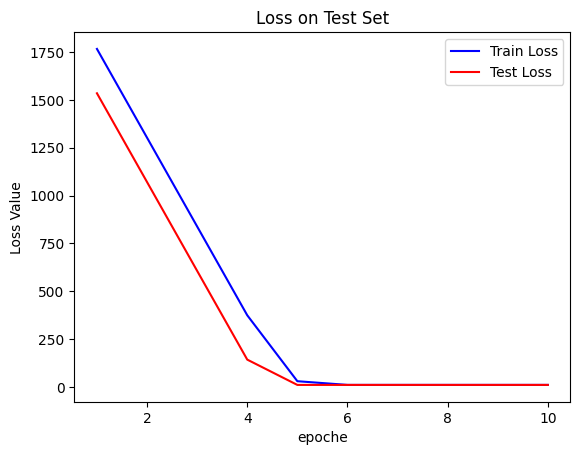

In [21]:
plt.plot(epoche, train_losses_hist, 'b', label='Train Loss')
plt.title('Loss on Training Set')
plt.xlabel('epoche')
plt.ylabel('Loss Value')

plt.plot(epoche, test_losses_hist, 'r', label='Test Loss')
plt.title('Loss on Test Set')
plt.xlabel('epoche')
plt.ylabel('Loss Value')
plt.legend()

plt.show()

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [22]:
set_random_seed(4)

In [23]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [24]:
scaler = StandardScaler()

# Скейлим наши данные
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
class LinearRegressionModel(nn.Module):

    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

In [26]:
# https://gist.github.com/jamesr2323/33c67ba5ac29880171b63d2c7f1acdc5

class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

In [27]:
# Снова сошлюсь на свой опыт https://github.com/oleggikk/CW-Transformers

In [28]:
def train(n_epochs ,model, optimizer, criterion, train_loader, test_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    train_losses = []
    test_losses = []
    
    for epoch in range(n_epochs):
        curr_train_loss = []
        for x_train, y_train in tqdm(train_loader):
            x_train = x_train.to(device, dtype=torch.float32)
            y_train = y_train.to(device, dtype=torch.float32)
            
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)  
            loss.backward()
            
            curr_train_loss.append(loss.cpu().detach().numpy())
            
            optimizer.step()
            optimizer.zero_grad()
            
        train_losses.append(curr_train_loss)
        
        current_loss = []
        with torch.no_grad():
            for x_test, y_test in tqdm(test_loader):
                x_test = x_test.to(device, dtype=torch.float32)
                y_test = y_test.to(device, dtype=torch.float32)

                y_pred_test = model(x_test)
                loss = criterion(y_pred_test, y_test)
        
                current_loss.append(loss.cpu().numpy())
        test_losses.append(current_loss)
        print(f"Epoch : {epoch+1} - loss : {np.mean(train_losses[-1]):.4f} - test_loss : {np.mean(current_loss):.4f}\n") 
                    
    return train_losses, test_losses


def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    predicts = []
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test = x_test.to(device, dtype=torch.float32)
            y_pred = model(x_test)
            predicts.extend(y_pred.cpu().numpy())
        
    predicts = np.array(predicts)
    predicts = torch.tensor(predicts)
    
    return predicts


In [29]:
import torch.optim as optim
lr = 0.01
num_epoches = 10
batch_size = 32
input_size = len(df.columns) - 1 # df - исходная таблица с 91 колонкой (1 колонка - целевые)
output_size = 1

In [30]:
train_set = TensorDataset(torch.from_numpy(X_train_scaled), torch.from_numpy(y_train.reshape(-1, 1)))
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = TensorDataset(torch.from_numpy(X_test_scaled), torch.from_numpy(y_test.reshape(-1, 1)))
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

model = LinearRegressionModel(input_size, output_size)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
model.to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
criterion = RMSELoss()  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

In [31]:
train_loss, test_loss = train(num_epoches, model, optimizer, criterion, train_loader, test_loader)

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch : 1 - loss : 1925.9974 - test_loss : 1853.5116



  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch : 2 - loss : 1781.1138 - test_loss : 1708.4929



  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch : 3 - loss : 1636.1111 - test_loss : 1563.4868



  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch : 4 - loss : 1491.0577 - test_loss : 1418.4889



  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch : 5 - loss : 1345.9988 - test_loss : 1273.3152



  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch : 6 - loss : 1200.9343 - test_loss : 1128.3636



  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch : 7 - loss : 1055.8760 - test_loss : 983.2270



  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch : 8 - loss : 910.8210 - test_loss : 838.2119



  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch : 9 - loss : 765.7676 - test_loss : 693.1425



  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch : 10 - loss : 620.7178 - test_loss : 548.2528



In [32]:
epoche = [x for x in range(1, 11)]
train_losses_hist = [np.mean(x) for x in train_loss]
test_losses_hist = [np.mean(x) for x in test_loss]

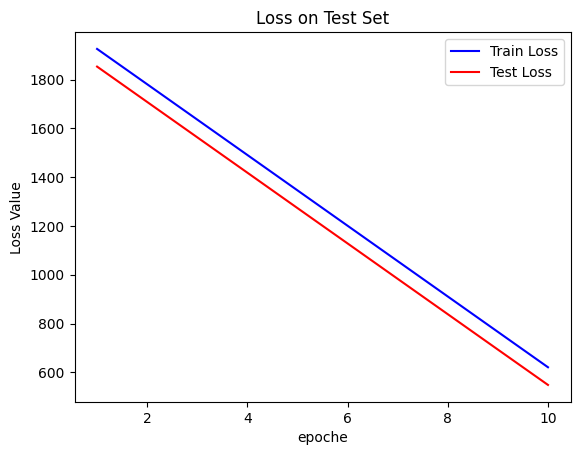

In [33]:
plt.plot(epoche, train_losses_hist, 'b', label='Train Loss')
plt.title('Loss on Training Set')
plt.xlabel('epoche')
plt.ylabel('Loss Value')

plt.plot(epoche, test_losses_hist, 'r', label='Test Loss')
plt.title('Loss on Test Set')
plt.xlabel('epoche')
plt.ylabel('Loss Value')
plt.legend()

plt.show()

In [34]:
# Ошибка достаточно большая, замечательно! Давайте увеличим batch_size, может будет лучше

In [35]:
lr = 0.01
num_epoches = 10
batch_size = 64
input_size = len(df.columns) - 1 # df - исходная таблица с 91 колонкой (1 колонка - целевые)
output_size = 1

In [36]:
import torch.optim as optim

train_set = TensorDataset(torch.from_numpy(X_train_scaled), torch.from_numpy(y_train.reshape(-1, 1)))
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = TensorDataset(torch.from_numpy(X_test_scaled), torch.from_numpy(y_test.reshape(-1, 1)))
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

model = LinearRegressionModel(input_size, output_size)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
model.to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
criterion = RMSELoss()  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

In [37]:
train_loss, test_loss = train(num_epoches, model, optimizer, criterion, train_loader, test_loader)

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 1 - loss : 1962.1915 - test_loss : 1925.9452



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 2 - loss : 1889.7271 - test_loss : 1853.5264



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 3 - loss : 1817.2874 - test_loss : 1780.9423



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 4 - loss : 1744.8573 - test_loss : 1708.4631



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 5 - loss : 1672.3466 - test_loss : 1636.1082



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 6 - loss : 1599.8109 - test_loss : 1563.5037



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 7 - loss : 1527.2815 - test_loss : 1491.0507



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 8 - loss : 1454.7522 - test_loss : 1418.5892



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 9 - loss : 1382.2258 - test_loss : 1345.9658



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 10 - loss : 1309.6947 - test_loss : 1273.3203



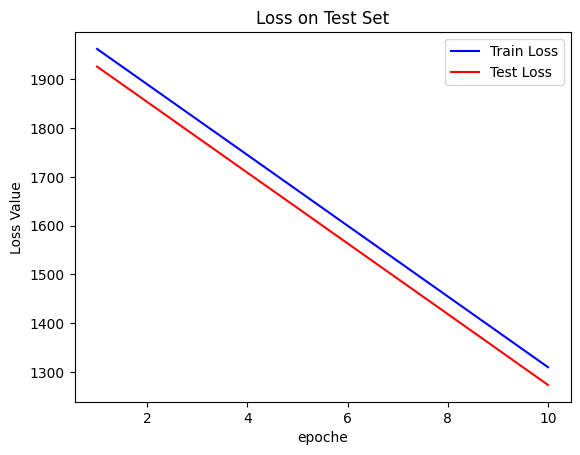

In [38]:
epoche = [x for x in range(1, 11)]
train_losses_hist = [np.mean(x) for x in train_loss]
test_losses_hist = [np.mean(x) for x in test_loss]

plt.plot(epoche, train_losses_hist, 'b', label='Train Loss')
plt.title('Loss on Training Set')
plt.xlabel('epoche')
plt.ylabel('Loss Value')

plt.plot(epoche, test_losses_hist, 'r', label='Test Loss')
plt.title('Loss on Test Set')
plt.xlabel('epoche')
plt.ylabel('Loss Value')
plt.legend()

plt.show()

In [39]:
# Стали учиться значительно медленнее, но быстрее по времени, попробуем увеличить LR

In [40]:
lr = 0.1
num_epoches = 10
batch_size = 64
input_size = len(df.columns) - 1 # df - исходная таблица с 91 колонкой (1 колонка - целевые)
output_size = 1

In [41]:
import torch.optim as optim

train_set = TensorDataset(torch.from_numpy(X_train_scaled), torch.from_numpy(y_train.reshape(-1, 1)))
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = TensorDataset(torch.from_numpy(X_test_scaled), torch.from_numpy(y_test.reshape(-1, 1)))
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

model = LinearRegressionModel(input_size, output_size)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
model.to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
criterion = RMSELoss()  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

In [42]:
train_loss, test_loss = train(num_epoches, model, optimizer, criterion, train_loader, test_loader)

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 1 - loss : 1636.5459 - test_loss : 1274.2729



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 2 - loss : 912.1088 - test_loss : 549.5014



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 3 - loss : 211.4991 - test_loss : 8.8924



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 4 - loss : 9.7850 - test_loss : 8.8914



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 5 - loss : 9.7874 - test_loss : 8.9623



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 6 - loss : 9.7898 - test_loss : 8.8531



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 7 - loss : 9.7866 - test_loss : 8.8243



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 8 - loss : 9.7892 - test_loss : 8.9894



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 9 - loss : 9.7840 - test_loss : 8.8537



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 10 - loss : 9.7781 - test_loss : 8.8073



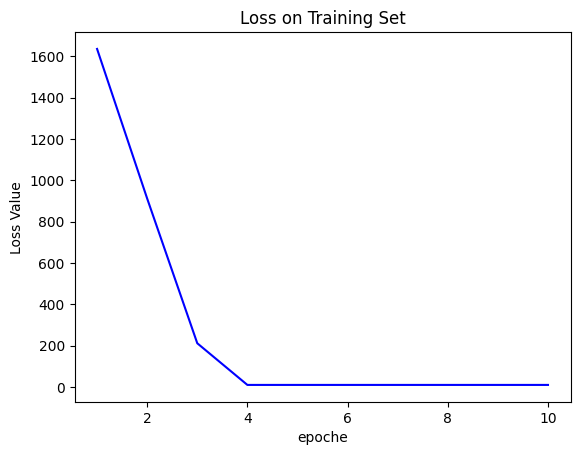

In [44]:
epoche = [x for x in range(1, 11)]
train_losses_hist = [np.mean(x) for x in train_loss]
test_losses_hist = [np.mean(x) for x in test_loss]

plt.plot(epoche, train_losses_hist, 'b', label='Train Loss')
plt.title('Loss on Training Set')
plt.xlabel('epoche')
plt.ylabel('Loss Value')

plt.show()

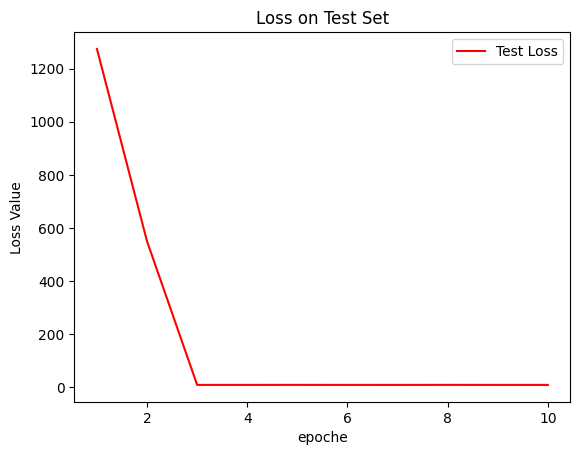

In [45]:
plt.plot(epoche, test_losses_hist, 'r', label='Test Loss')
plt.title('Loss on Test Set')
plt.xlabel('epoche')
plt.ylabel('Loss Value')
plt.legend()

plt.show()

In [46]:
# Теперь учимся быстрее во всех смыслах, но ошибка все еще не на 10 баллов, 
# Но я мог поставить критерй останова, давайте попробуем нормировать таргет, и тк он будет заскейленым - сразу уменьшу lr

In [47]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [48]:
scaler = StandardScaler()

# Скейлим наши данные
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Скейлим таргет
scaler_for_target = StandardScaler()
y_train_scaled = scaler_for_target.fit_transform(y_train.reshape(-1, 1))

In [49]:
lr = 0.01
num_epoches = 10
batch_size = 64
input_size = len(df.columns) - 1 # df - исходная таблица с 91 колонкой (1 колонка - целевые)
output_size = 1

In [50]:
import torch.optim as optim

train_set = TensorDataset(torch.from_numpy(X_train_scaled), torch.from_numpy(y_train_scaled.reshape(-1, 1)))
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = TensorDataset(torch.from_numpy(X_test_scaled), torch.from_numpy(y_test.reshape(-1, 1)))
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

model = LinearRegressionModel(input_size, output_size)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
model.to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
criterion = RMSELoss()  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

In [51]:
# Чтоб корректно проходило обучение нужно еще и функцию обучения поменять

In [52]:
def train(n_epochs ,model, optimizer, criterion, train_loader, test_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    train_losses = []
    test_losses = []
    
    for epoch in range(n_epochs):
        curr_train_loss = []
        for x_train, y_train in tqdm(train_loader):
            x_train = x_train.to(device, dtype=torch.float32)
            y_train = y_train.to(device, dtype=torch.float32)
            
            y_pred = model(x_train)
            
            loss = criterion(y_pred, y_train)  
            loss.backward()
            
            curr_train_loss.append(loss.cpu().detach().numpy())
            
            optimizer.step()
            optimizer.zero_grad()
            
        train_losses.append(curr_train_loss)
        
        current_loss = []
        with torch.no_grad():
            for x_test, y_test in tqdm(test_loader):
                x_test = x_test.to(device, dtype=torch.float32)
                y_test = y_test.to(device, dtype=torch.float32)

                y_pred_test = model(x_test)
                y_pred_test = scaler_for_target.inverse_transform(y_pred_test.cpu().numpy().reshape(-1, 1))
                y_pred_test = torch.from_numpy(y_pred_test).to(device, dtype=torch.float32)
                
                loss = criterion(y_pred_test, y_test)
        
                current_loss.append(loss.cpu().numpy())
        test_losses.append(current_loss)
        print(f"Epoch : {epoch+1} - loss : {np.mean(train_losses[-1]):.4f} - test_loss : {np.mean(current_loss):.4f}\n") 
                    
    return train_losses, test_losses


def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    predicts = []
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test = x_test.to(device, dtype=torch.float32)
            y_pred = model(x_test)
            y_pred = scaler_for_target.inverse_transform(y_pred)
            predicts.extend(y_pred.cpu().numpy())
        
    predicts = np.array(predicts)
    predicts = torch.tensor(predicts)
    
    return predicts


In [53]:
train_loss, test_loss = train(num_epoches, model, optimizer, criterion, train_loader, test_loader)

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.8988 - test_loss : 8.7473



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.8981 - test_loss : 8.9075



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.8976 - test_loss : 9.1235



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.8972 - test_loss : 9.3008



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.8978 - test_loss : 8.7794



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.8976 - test_loss : 8.9464



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.8974 - test_loss : 8.9154



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.8980 - test_loss : 8.7222



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.8980 - test_loss : 8.9745



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.8977 - test_loss : 9.2933



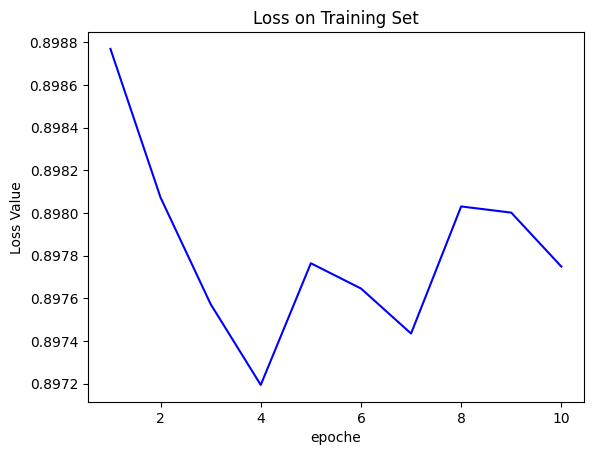

In [55]:
epoche = [x for x in range(1, 11)]
train_losses_hist = [np.mean(x) for x in train_loss]
test_losses_hist = [np.mean(x) for x in test_loss]

plt.plot(epoche, train_losses_hist, 'b', label='Train Loss')
plt.title('Loss on Training Set')
plt.xlabel('epoche')
plt.ylabel('Loss Value')

plt.show()

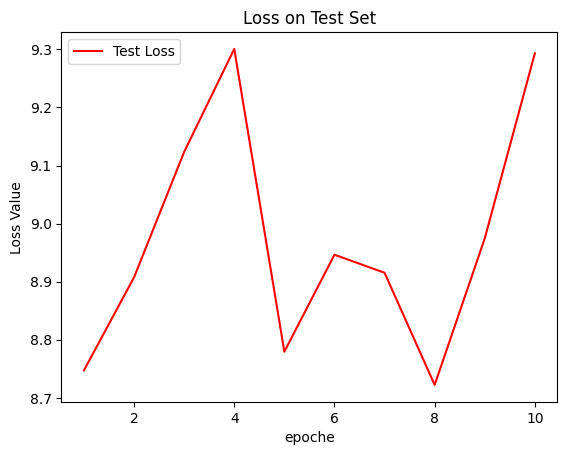

In [56]:
plt.plot(epoche, test_losses_hist, 'r', label='Test Loss')
plt.title('Loss on Test Set')
plt.xlabel('epoche')
plt.ylabel('Loss Value')
plt.legend()

plt.show()

In [ ]:
# Видим, что мы уже сходили к красивому RMSE, не имеет смысла обучаться на 10 эпохах, поставим 5, и еще чуточку уменьшим LR

In [57]:
lr = 0.001
num_epoches = 5
batch_size = 64
input_size = len(df.columns) - 1 # df - исходная таблица с 91 колонкой (1 колонка - целевые)
output_size = 1

In [58]:
import torch.optim as optim

train_set = TensorDataset(torch.from_numpy(X_train_scaled), torch.from_numpy(y_train_scaled.reshape(-1, 1)))
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = TensorDataset(torch.from_numpy(X_test_scaled), torch.from_numpy(y_test.reshape(-1, 1)))
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

model = LinearRegressionModel(input_size, output_size)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
model.to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
criterion = RMSELoss()  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

In [59]:
train_loss, test_loss = train(num_epoches, model, optimizer, criterion, train_loader, test_loader)

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.8730 - test_loss : 8.5228



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.8669 - test_loss : 8.6029



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.8669 - test_loss : 8.5902



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.8669 - test_loss : 8.5681



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.8670 - test_loss : 8.5895



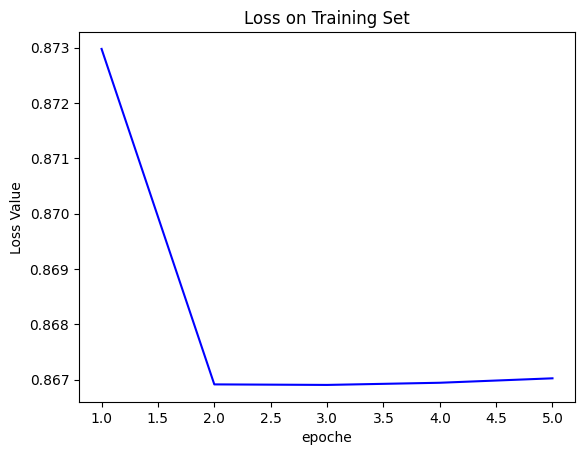

In [61]:
epoche = [x for x in range(1, 6)]
train_losses_hist = [np.mean(x) for x in train_loss]
test_losses_hist = [np.mean(x) for x in test_loss]

plt.plot(epoche, train_losses_hist, 'b', label='Train Loss')
plt.title('Loss on Training Set')
plt.xlabel('epoche')
plt.ylabel('Loss Value')

plt.show()

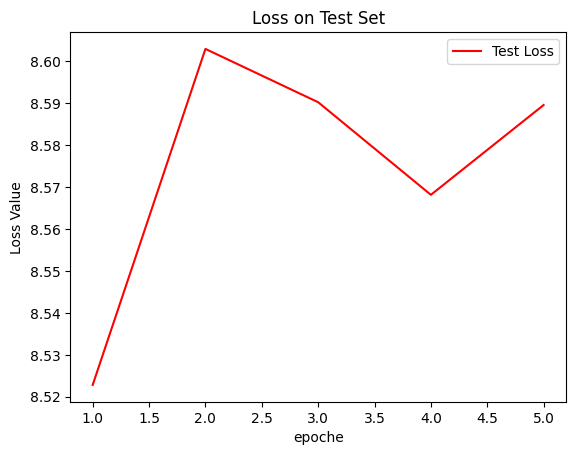

In [62]:
plt.plot(epoche, test_losses_hist, 'r', label='Test Loss')
plt.title('Loss on Test Set')
plt.xlabel('epoche')
plt.ylabel('Loss Value')
plt.legend()

plt.show()

In [63]:
# Кто-то говорил "Бесконечность не предел", щас будет дропаут

In [64]:
# Добавим dropout
def train(n_epochs ,model, optimizer, criterion, train_loader, test_loader, dropout):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
        dropout - float, probability of an element to be zeroed in dropout layer
    """
    train_losses = []
    test_losses = []
    
    for epoch in range(n_epochs):
        curr_train_loss = []
        model.train()
        for x_train, y_train in tqdm(train_loader):
            x_train = x_train.to(device, dtype=torch.float32)
            y_train = y_train.to(device, dtype=torch.float32)
            
            optimizer.zero_grad()
            
            y_pred = model(x_train)
            
            loss = criterion(y_pred, y_train)  
            loss.backward()
            
            curr_train_loss.append(loss.cpu().detach().numpy())
            
            optimizer.step()
            
            # Dropout
            if dropout is not None:
                with torch.no_grad():
                    x_train = F.dropout(x_train, p=dropout)
            
        train_losses.append(curr_train_loss)
        
        current_loss = []
        model.eval()
        with torch.no_grad():
            for x_test, y_test in tqdm(test_loader):
                x_test = x_test.to(device, dtype=torch.float32)
                y_test = y_test.to(device, dtype=torch.float32)

                y_pred_test = model(x_test)
                y_pred_test = scaler_for_target.inverse_transform(y_pred_test.cpu().numpy().reshape(-1, 1))
                y_pred_test = torch.from_numpy(y_pred_test).to(device, dtype=torch.float32)

                loss = criterion(y_pred_test, y_test)
        
                current_loss.append(loss.cpu().numpy())
        test_losses.append(current_loss)
        print(f"Epoch : {epoch+1} - loss : {np.mean(train_losses[-1]):.4f} - test_loss : {np.mean(current_loss):.4f}\n") 
                    
    return train_losses, test_losses

In [65]:
lr = 0.001
num_epoches = 5
batch_size = 64
input_size = len(df.columns) - 1 # df - исходная таблица с 91 колонкой (1 колонка - целевые)
output_size = 1
dropout = 0.02

In [66]:
import torch.optim as optim

train_set = TensorDataset(torch.from_numpy(X_train_scaled), torch.from_numpy(y_train_scaled.reshape(-1, 1)))
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = TensorDataset(torch.from_numpy(X_test_scaled), torch.from_numpy(y_test.reshape(-1, 1)))
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

model = LinearRegressionModel(input_size, output_size)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
model.to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
criterion = RMSELoss()  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

In [67]:
train_loss, test_loss = train(num_epoches, model, optimizer, criterion, train_loader, test_loader, dropout)

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.8719 - test_loss : 8.5626



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.8669 - test_loss : 8.5610



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.8669 - test_loss : 8.5504



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.8672 - test_loss : 8.5612



  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.8671 - test_loss : 8.5347



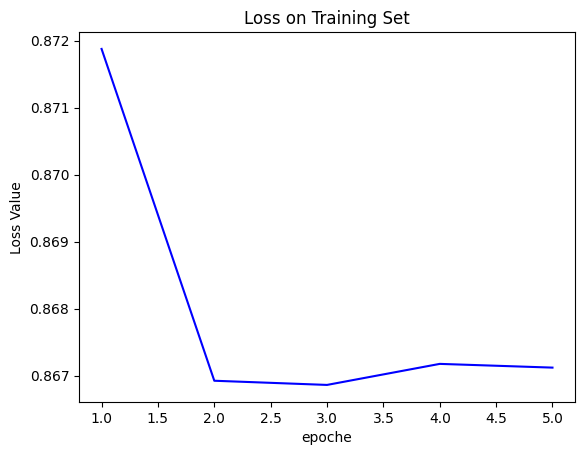

In [68]:
epoche = [x for x in range(1, 6)]
train_losses_hist = [np.mean(x) for x in train_loss]
test_losses_hist = [np.mean(x) for x in test_loss]

plt.plot(epoche, train_losses_hist, 'b', label='Train Loss')
plt.title('Loss on Training Set')
plt.xlabel('epoche')
plt.ylabel('Loss Value')

plt.show()

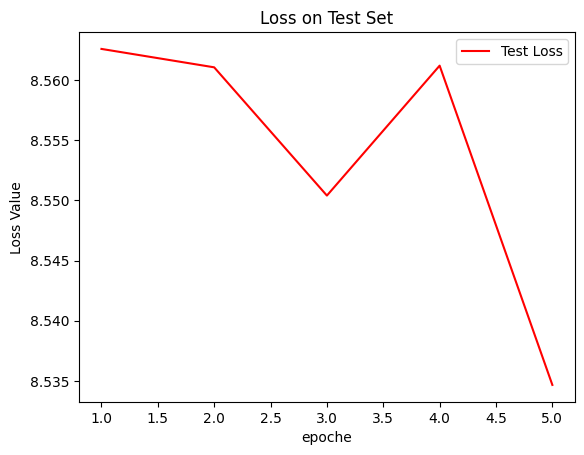

In [69]:
plt.plot(epoche, test_losses_hist, 'r', label='Test Loss')
plt.title('Loss on Test Set')
plt.xlabel('epoche')
plt.ylabel('Loss Value')
plt.legend()

plt.show()

In [ ]:
# Возможно Батч-Сайз все же слишком большой и можно лучше

In [70]:
lr = 0.001
num_epoches = 5
batch_size = 32
input_size = len(df.columns) - 1 # df - исходная таблица с 91 колонкой (1 колонка - целевые)
output_size = 1
dropout = 0.02

In [71]:
import torch.optim as optim

train_set = TensorDataset(torch.from_numpy(X_train_scaled), torch.from_numpy(y_train_scaled.reshape(-1, 1)))
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = TensorDataset(torch.from_numpy(X_test_scaled), torch.from_numpy(y_test.reshape(-1, 1)))
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

model = LinearRegressionModel(input_size, output_size)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
model.to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
criterion = RMSELoss()  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

In [72]:
train_loss, test_loss = train(num_epoches, model, optimizer, criterion, train_loader, test_loader, dropout)

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.8622 - test_loss : 8.3159



  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.8591 - test_loss : 8.3017



  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.8593 - test_loss : 8.3461



  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.8594 - test_loss : 8.2912



  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.8594 - test_loss : 8.2826



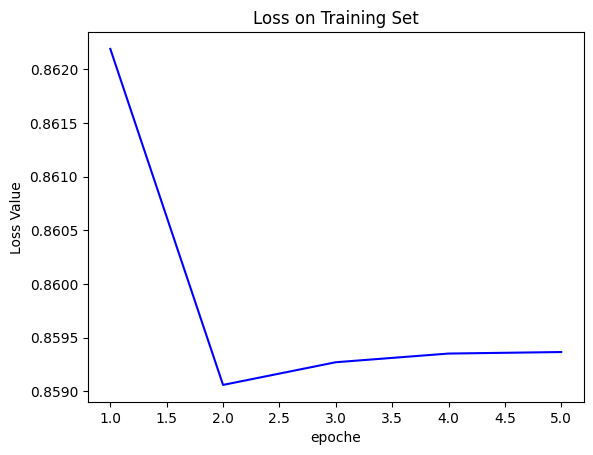

In [74]:
epoche = [x for x in range(1, 6)]
train_losses_hist = [np.mean(x) for x in train_loss]
test_losses_hist = [np.mean(x) for x in test_loss]

plt.plot(epoche, train_losses_hist, 'b', label='Train Loss')
plt.title('Loss on Training Set')
plt.xlabel('epoche')
plt.ylabel('Loss Value')

plt.show()

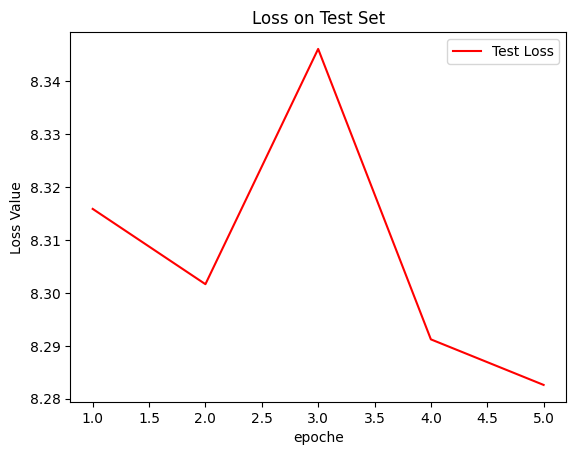

In [75]:
plt.plot(epoche, test_losses_hist, 'r', label='Test Loss')
plt.title('Loss on Test Set')
plt.xlabel('epoche')
plt.ylabel('Loss Value')
plt.legend()

plt.show()

In [ ]:
# ೭੧(❛〜❛✿)੭೨ Go forward!
# Я считаю, что это успех

In [ ]:
# Но давайте еще уменьшим батч сайз

In [76]:
lr = 0.001
num_epoches = 5
batch_size = 16
input_size = len(df.columns) - 1 # df - исходная таблица с 91 колонкой (1 колонка - целевые)
output_size = 1
dropout = 0.02

In [77]:
import torch.optim as optim

train_set = TensorDataset(torch.from_numpy(X_train_scaled), torch.from_numpy(y_train_scaled.reshape(-1, 1)))
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = TensorDataset(torch.from_numpy(X_test_scaled), torch.from_numpy(y_test.reshape(-1, 1)))
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

model = LinearRegressionModel(input_size, output_size)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
model.to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
criterion = RMSELoss()  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

In [78]:
train_loss, test_loss = train(num_epoches, model, optimizer, criterion, train_loader, test_loader, dropout)

  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.8458 - test_loss : 7.9437



  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.8435 - test_loss : 7.9548



  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.8436 - test_loss : 7.9992



  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.8435 - test_loss : 8.0217



  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.8440 - test_loss : 8.0483



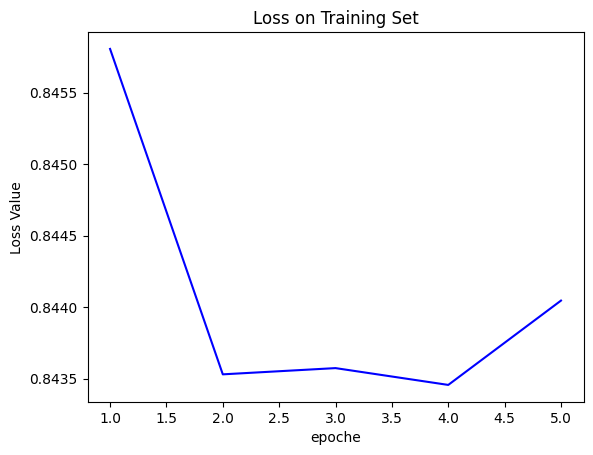

In [80]:
epoche = [x for x in range(1, 6)]
train_losses_hist = [np.mean(x) for x in train_loss]
test_losses_hist = [np.mean(x) for x in test_loss]

plt.plot(epoche, train_losses_hist, 'b', label='Train Loss')
plt.title('Loss on Training Set')
plt.xlabel('epoche')
plt.ylabel('Loss Value')

plt.show()

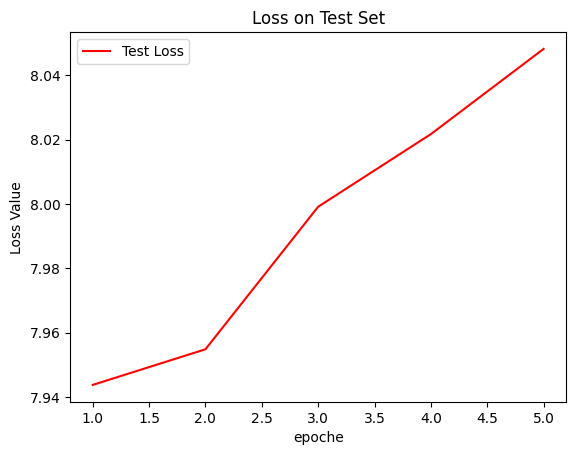

In [81]:
plt.plot(epoche, test_losses_hist, 'r', label='Test Loss')
plt.title('Loss on Test Set')
plt.xlabel('epoche')
plt.ylabel('Loss Value')
plt.legend()

plt.show()

In [ ]:
# Видим, что на первой эпохе максимальная точность, дальше и не надо учиться было

In [ ]:
# только что доделал ДЗ, 783 запуска ячеек :) Но еще раз 10 умер кернел

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

In [82]:
# Эксперементов > 3
# Ну начал я с лекции и выбора оптимизатора - вспомнил слова Евгения Соколова, что вот есть Adagrad и есть Momentum,
# От них взяли самое лучшее - получили Adam, 
# Дальше Я решил увеличить размер батча, вообще преследовал цель увеличить точность, но за счет большего разбиения по
# Батчам еще увеличилась и скорость обучения (время), но упала скорость фактического обучения, принял решение, что нужно 
# работать с лернинг рейтом, чтоб веса при параметах быстрее сходились к локальному минимуму. 
# оно и произошло, RMSE упало меньше 8.9, понятно стало, что пора работать с данными, зашкалировал(нормировал) целевую
# переменную, переделал цикл обучения, тк теперь надо трансформить для подсчета лосса предикшны, результат уже был хороший,
# модель выбивала 8,75 (запусков было больше 1), решил, что зря батч-сайз увеличивал, вернул его к 32, тут и RMSE удалось побить
# Но стало интересно к чему моно прийти с дропаутом, чекнул документацию торча, нашел строчку, закинул в цикл обучения.
# Dropout - метод регуляризации искусственных нейронных сетей, предназначен для уменьшения переобучения сети за счет предотвращения 
# сложных коадаптаций отдельных нейронов на тренировочных данных во время обучения.
# Еще понизил батч сайз, и вот RMSE < 8
# Полносвязная однослойня нейронная сеть - простая конструкция, где каждый нейрон соединен со всеми нейронами предыдущего слоя. 
# Входные данные проходят через слой, где каждый нейрон вычисляет взвешенную сумму и применяет активационную функцию. 
# Выход слоя является результатом модели.